# Analyse Exploratoire

### Import des modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np 
import json

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import bentoml

### Analyse Exploratoire

In [2]:
building_consumption = pd.read_csv('../data/2016_Building_Energy_Benchmarking.csv')

In [3]:
# On regarde comment un batiment est défini dans ce jeu de données 
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [4]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [5]:
# On regarde les valeurs dans Building Type
building_consumption['BuildingType'].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [6]:
# On conserve uniquement les batiments BuildingType qui sont NonResidential, SPS-District K-12, Nonresidential COS et Nonresidential WA
building_consumption = building_consumption[building_consumption['BuildingType'].isin(['NonResidential', 'SPS-District K-12', 'Nonresidential COS', 'Nonresidential WA'])]

In [7]:
building_consumption.shape

(1644, 46)

In [8]:
building_consumption['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office    292
Other                          243
Warehouse                      187
Large Office                   172
K-12 School                    135
Mixed Use Property             110
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Office                           3
Low-Rise Multifamily             2
Name: count, dtype: int64

In [9]:
# On regarde les statistiques descriptives des variables numériques
building_consumption.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,1644.000000,1644.0,1628.000000,1644.000000,1644.000000,1644.000000,1644.000000,1642.000000,1644.000000,1.644000e+03,...,1.642000e+03,1.641000e+03,1.642000e+03,1.642000e+03,1.642000e+03,1.642000e+03,1.642000e+03,0.0,1642.000000,1642.000000
mean,16314.106448,2016.0,98116.876536,4.361922,47.616246,-122.332957,1961.925791,1.034105,4.144769,1.106277e+05,...,7.373224e+06,7.492230e+06,4.655966e+05,1.528241e+06,5.214360e+06,1.660929e+04,1.660929e+06,NaN,160.501760,1.570402
std,13824.494495,0.0,18.492115,2.188563,0.048141,0.024615,32.695137,0.552039,6.603893,1.865990e+05,...,1.814333e+07,1.830007e+07,5.146583e+06,3.717491e+06,1.268408e+07,5.352787e+04,5.352787e+06,NaN,554.183554,2.186648
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.411820,1900.000000,0.000000,0.000000,1.128500e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,584.750000,2016.0,98105.000000,2.000000,47.585515,-122.343290,1930.000000,1.000000,1.000000,2.939350e+04,...,1.215744e+06,1.280846e+06,0.000000e+00,2.105215e+05,7.182992e+05,0.000000e+00,0.000000e+00,NaN,19.780000,0.340000
50%,21140.500000,2016.0,98109.000000,4.000000,47.612480,-122.332935,1965.000000,1.000000,2.000000,4.898850e+04,...,2.498541e+06,2.644410e+06,0.000000e+00,4.672902e+05,1.594394e+06,4.835180e+03,4.835180e+05,NaN,49.105000,0.860000
75%,24602.250000,2016.0,98125.000000,7.000000,47.649752,-122.321748,1989.000000,1.000000,4.000000,1.030000e+05,...,6.785911e+06,7.034168e+06,0.000000e+00,1.387276e+06,4.733386e+06,1.446404e+04,1.446404e+06,NaN,134.815000,1.877500
max,50226.000000,2016.0,98199.000000,7.000000,47.733870,-122.258640,2015.000000,9.000000,99.000000,1.952220e+06,...,2.930908e+08,2.966717e+08,1.349435e+08,8.046087e+07,2.745325e+08,1.381912e+06,1.381912e+08,NaN,12307.160000,25.710000


In [10]:
# Qualité des données.
building_consumption.isna().mean().sort_values(ascending=False)

Comments                           1.000000
Outlier                            0.989659
YearsENERGYSTARCertified           0.940389
ThirdLargestPropertyUseType        0.789538
ThirdLargestPropertyUseTypeGFA     0.789538
SecondLargestPropertyUseType       0.486618
SecondLargestPropertyUseTypeGFA    0.486618
ENERGYSTARScore                    0.337591
ZipCode                            0.009732
LargestPropertyUseType             0.003650
LargestPropertyUseTypeGFA          0.003650
SiteEUIWN(kBtu/sf)                 0.001825
SiteEUI(kBtu/sf)                   0.001825
SiteEnergyUseWN(kBtu)              0.001825
SteamUse(kBtu)                     0.001217
SiteEnergyUse(kBtu)                0.001217
SourceEUIWN(kBtu/sf)               0.001217
SourceEUI(kBtu/sf)                 0.001217
Electricity(kWh)                   0.001217
Electricity(kBtu)                  0.001217
NaturalGas(therms)                 0.001217
NaturalGas(kBtu)                   0.001217
TotalGHGEmissions               

In [11]:
# On supprime les colonnes avec beaucoup de valeurs manquantes et les colonnes non pertinentes
# Définitions ici https://data.seattle.gov/Built-Environment/Building-Energy-Benchmarking-Data-2015-Present/teqw-tu6e/about_data
columns_to_drop = ['Comments',
                   'Outlier',
                   'DataYear',
                   'YearsENERGYSTARCertified',
                   'OSEBuildingID', 
                   'SiteEUIWN(kBtu/sf)', 
                   'SourceEUIWN(kBtu/sf)', 
                   'SourceEnergyUseWN(kBtu)', 
                   'GHGEmissionsIntensity', 
                   'Longitude', 
                   'Latitude',  
                   'Neighborhood',  
                   'LargestPropertyUseTypeGFA', 
                   'SecondLargestPropertyUseType',
                   'SecondLargestPropertyUseTypeGFA', 
                   'ThirdLargestPropertyUseType', 
                   'ThirdLargestPropertyUseTypeGFA',
                   'TaxParcelIdentificationNumber',
                   'Address',
                   'City',
                   'State',
                   'ZipCode',
                   'DefaultData',
                   #'ComplianceStatus',
                   'CouncilDistrictCode',
                   'PropertyName',
                   'SiteEUI(kBtu/sf) ',
                   'SourceEUI(kBtu/sf)',
                   'SourceEnergyUse(kBtu)',
                   'ENERGYSTARScore']

# Drop only existing columns to avoid KeyError if some names are missing in the dataframe
building_consumption = building_consumption.drop(columns=[c for c in columns_to_drop if c in building_consumption.columns])

In [12]:
# On regarde les colonnes restantes 
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1644 entries, 0 to 3375
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1644 non-null   object 
 1   PrimaryPropertyType        1644 non-null   object 
 2   YearBuilt                  1644 non-null   int64  
 3   NumberofBuildings          1642 non-null   float64
 4   NumberofFloors             1644 non-null   int64  
 5   PropertyGFATotal           1644 non-null   int64  
 6   PropertyGFAParking         1644 non-null   int64  
 7   PropertyGFABuilding(s)     1644 non-null   int64  
 8   ListOfAllPropertyUseTypes  1642 non-null   object 
 9   LargestPropertyUseType     1638 non-null   object 
 10  SiteEUI(kBtu/sf)           1641 non-null   float64
 11  SiteEnergyUse(kBtu)        1642 non-null   float64
 12  SiteEnergyUseWN(kBtu)      1641 non-null   float64
 13  SteamUse(kBtu)             1642 non-null   float64
 1

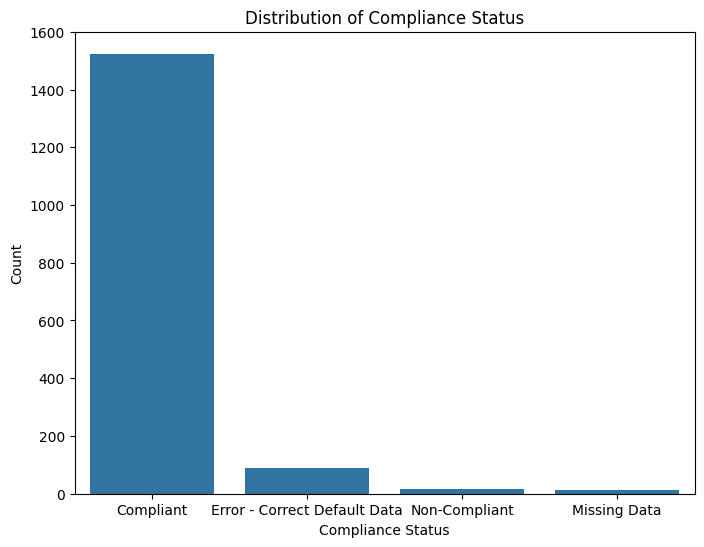

In [13]:
# Voir la distribution des valeurs ComplianceStatus
plt.figure(figsize=(8, 6))
sns.countplot(data=building_consumption, x='ComplianceStatus', order=building_consumption['ComplianceStatus'].value_counts().index)
plt.title('Distribution of Compliance Status')
plt.xlabel('Compliance Status')
plt.ylabel('Count')
plt.show()

In [14]:
# On regarde comment cela impacterait la taille du dataset si on supprimait les lignes ou ComplianceStatus != 'Compliant'
building_consumption_non_compliant = building_consumption[building_consumption['ComplianceStatus'] != 'Compliant']
building_consumption_non_compliant.shape


(120, 20)

In [15]:
# On supprime les lignes ou ComplianceStatus != 'Compliant'
building_consumption = building_consumption[building_consumption['ComplianceStatus'] == 'Compliant']
building_consumption.shape

(1524, 20)

In [16]:
# On supprime la colonne ComplianceStatus
building_consumption = building_consumption.drop(columns=['ComplianceStatus'])

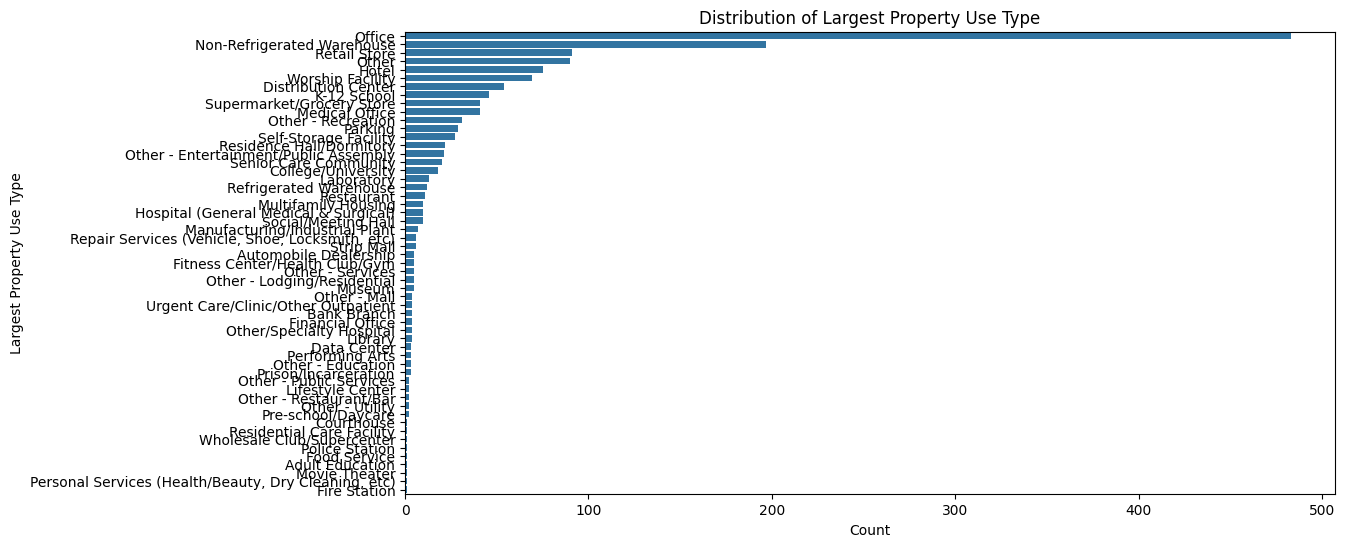

In [17]:
# Visualisation de la distribution de LargestPropertyUseType
plt.figure(figsize=(12,6))
sns.countplot(data=building_consumption, y='LargestPropertyUseType', order=building_consumption['LargestPropertyUseType'].value_counts().index)
plt.title('Distribution of Largest Property Use Type')
plt.xlabel('Count')
plt.ylabel('Largest Property Use Type')
plt.show()

In [18]:
# On regarde ListOfAllPropertyUseTypes
building_consumption['ListOfAllPropertyUseTypes'].value_counts()

ListOfAllPropertyUseTypes
Office                                                                                    132
Office, Parking                                                                           119
Non-Refrigerated Warehouse                                                                100
Non-Refrigerated Warehouse, Office                                                         61
Other                                                                                      55
                                                                                         ... 
Bar/Nightclub, Office, Personal Services (Health/Beauty, Dry Cleaning, etc)                 1
Medical Office, Parking, Retail Store                                                       1
Office, Other - Entertainment/Public Assembly, Other - Mall, Restaurant                     1
Office, Performing Arts, Restaurant, Retail Store, Self-Storage Facility                    1
Fitness Center/Health Club/Gym, Of

In [19]:
# On crée une liste de potentielles features pour la modélisation
potential_features = ['LargestPropertyUseType']

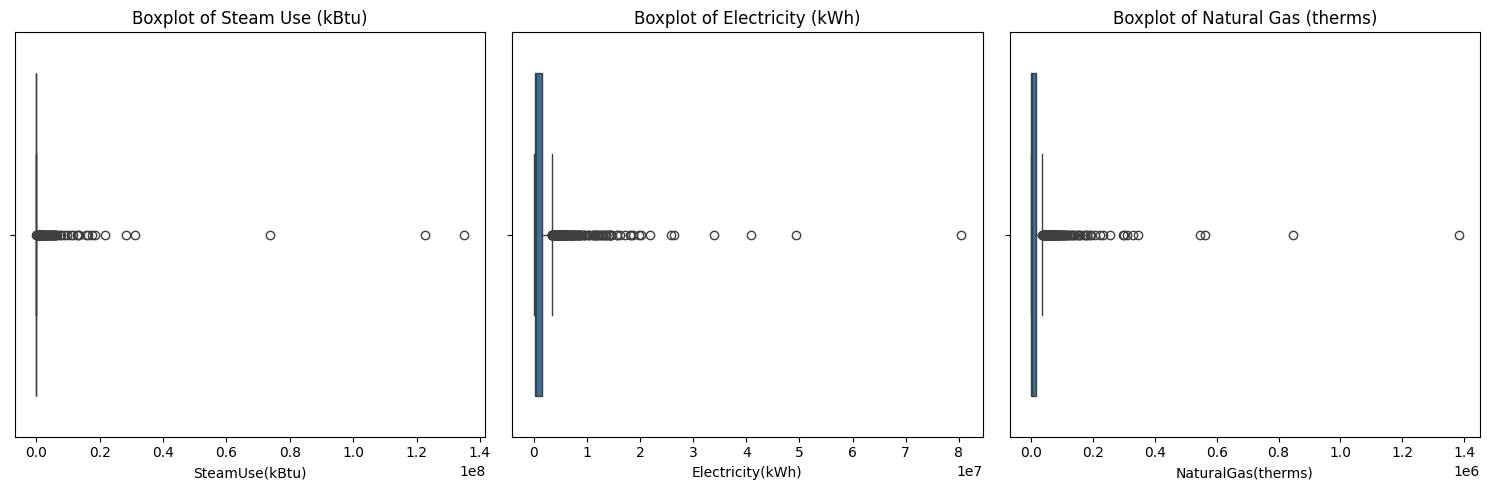

In [20]:
# On boxplot SteamUse(kBtu), Electricity(kWh), NaturalGas(therms)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(x='SteamUse(kBtu)', data=building_consumption)
plt.title('Boxplot of Steam Use (kBtu)')
plt.subplot(1,3,2)
sns.boxplot(x='Electricity(kWh)', data=building_consumption)
plt.title('Boxplot of Electricity (kWh)')
plt.subplot(1,3,3)
sns.boxplot(x='NaturalGas(therms)', data=building_consumption)
plt.title('Boxplot of Natural Gas (therms)')
plt.tight_layout()
plt.show()

In [21]:
# On ajoute ces variables aux potentielles features et on supprime les valeurs manquantes
potential_features.extend(['SteamUse(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)'])
building_consumption = building_consumption.dropna(subset=potential_features)

In [22]:
building_consumption.shape

(1520, 19)

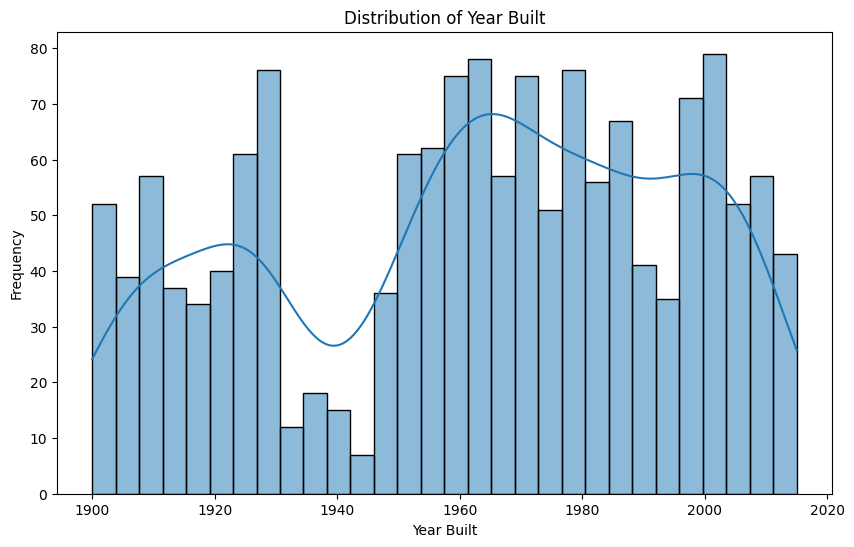

In [23]:
# Visualisation de la distribution de YearBuilt
plt.figure(figsize=(10,6))
sns.histplot(building_consumption['YearBuilt'], bins=30, kde=True)
plt.title('Distribution of Year Built')
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.show()

In [24]:
potential_features.extend(['YearBuilt'])

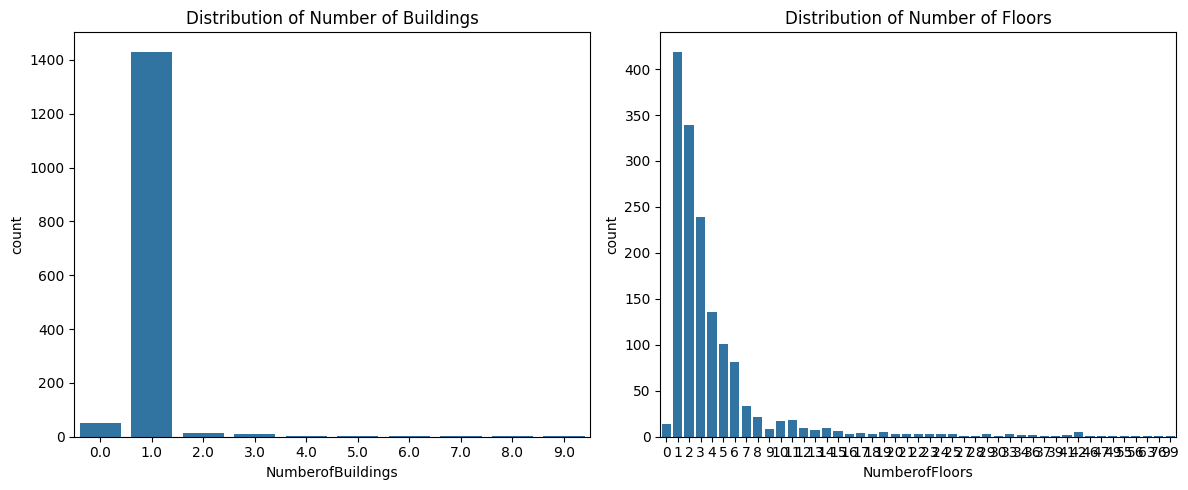

In [25]:
# Visualisation de NumberofBuildings et NumberofFloors
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x='NumberofBuildings', data=building_consumption)
plt.title('Distribution of Number of Buildings')
plt.subplot(1,2,2)
sns.countplot(x='NumberofFloors', data=building_consumption)
plt.title('Distribution of Number of Floors')
plt.tight_layout()
plt.show()

In [26]:
potential_features.extend(['NumberofBuildings', 'NumberofFloors'])

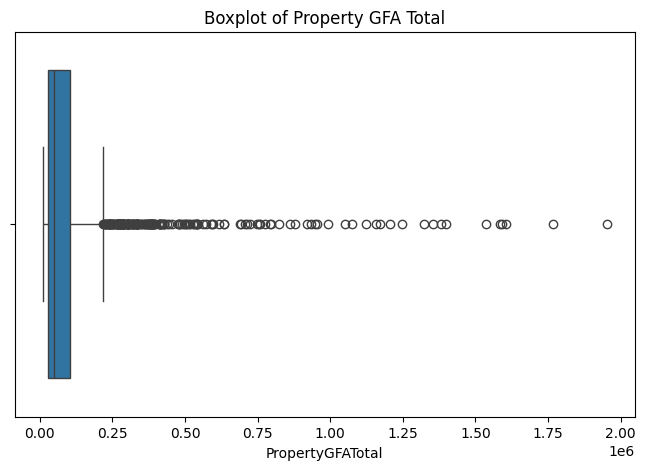

In [27]:
# Boxplot de PropertyGFATotal
plt.figure(figsize=(8,5))
sns.boxplot(x='PropertyGFATotal', data=building_consumption)
plt.title('Boxplot of Property GFA Total')
plt.show()

In [28]:
potential_features.extend(['PropertyGFATotal'])

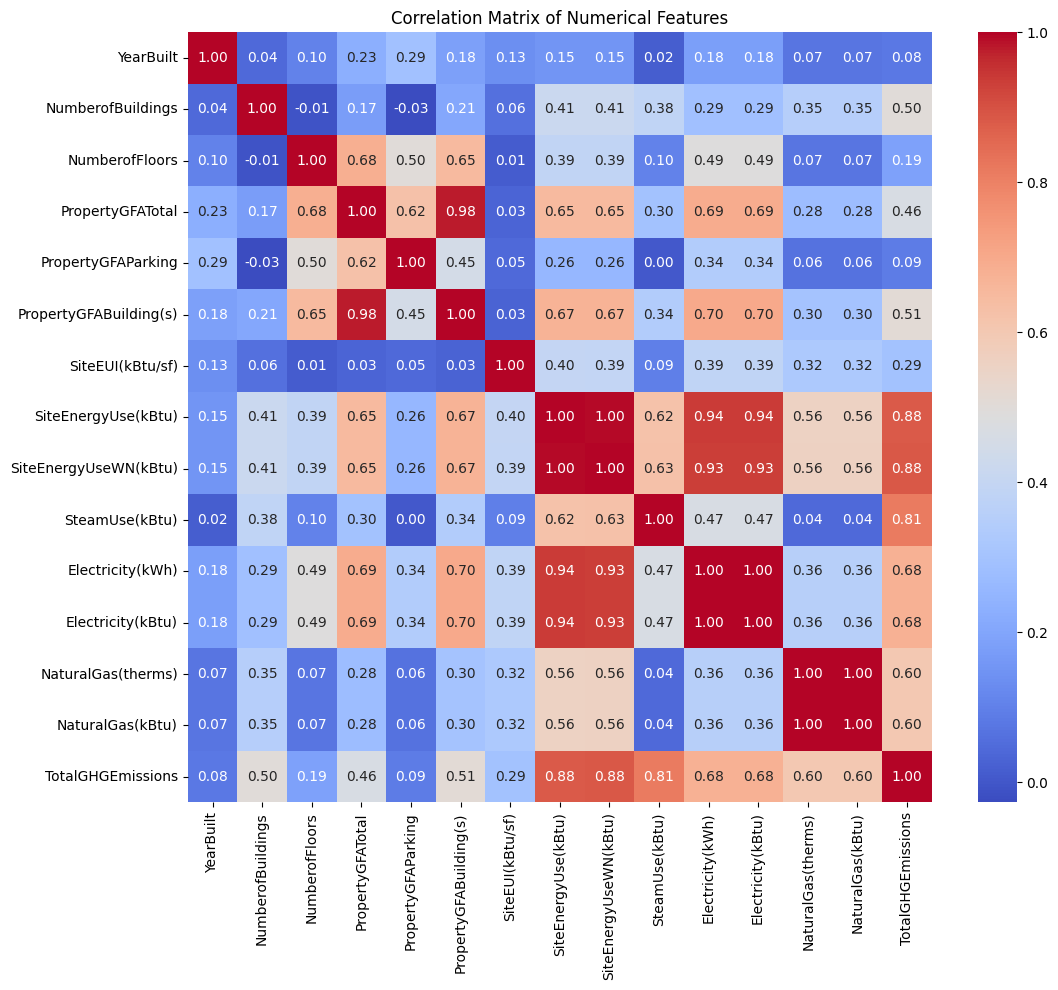

In [29]:
# On regarde la corrélation entre les variables numériques
numeric_cols = building_consumption.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12,10))
correlation_matrix = building_consumption[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### TERMINER L'ANALYSE EXPLORATOIRE 

A réaliser : 
- Une analyse descriptive des données, y compris une explication du sens des colonnes gardées, des arguments derrière la suppression de lignes ou de colonnes, des statistiques descriptives et des visualisations pertinentes.

# Modélisation 

### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

In [30]:
# Ajouter une colonne ancienneté du bâtiment et supprimer YearBuilt
building_consumption['BuildingAge'] = 2025 - building_consumption['YearBuilt']
building_consumption = building_consumption.drop(columns=['YearBuilt'])

# On ajoute BuildingAge aux potentielles features
potential_features.append('BuildingAge')


In [31]:
# On ajoute un des colonnes pour indiquer si usage SteamUse(kBtu) et NaturalGas(kBtu) 0 ou 1 si usage ou non 
building_consumption['UsesSteam'] = (building_consumption['SteamUse(kBtu)'] > 0).astype(int)
building_consumption['UsesNaturalGas'] = (building_consumption['NaturalGas(therms)'] > 0).astype(int)
building_consumption.head()

,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,SiteEUI(kBtu/sf),...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,UsesSteam,UsesNaturalGas
0,NonResidential,Hotel,1.0,12,88434,0,88434,Hotel,Hotel,81.699997,...,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,98,1,1
1,NonResidential,Hotel,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,94.800003,...,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,29,0,1
2,NonResidential,Hotel,1.0,41,956110,196718,759392,Hotel,Hotel,96.000000,...,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,2089.28,56,1,1
3,NonResidential,Hotel,1.0,10,61320,0,61320,Hotel,Hotel,110.800003,...,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,286.43,99,1,1
4,NonResidential,Hotel,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,114.800003,...,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,505.01,45,0,1


In [32]:
# On ajoute une colonne pour la presence parking
building_consumption['HasParking'] = (building_consumption['PropertyGFAParking'] > 0).astype(int)
building_consumption.head()

,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,SiteEUI(kBtu/sf),...,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,UsesSteam,UsesNaturalGas,HasParking
0,NonResidential,Hotel,1.0,12,88434,0,88434,Hotel,Hotel,81.699997,...,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,98,1,1,0
1,NonResidential,Hotel,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,94.800003,...,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,29,0,1,1
2,NonResidential,Hotel,1.0,41,956110,196718,759392,Hotel,Hotel,96.000000,...,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,2089.28,56,1,1,1
3,NonResidential,Hotel,1.0,10,61320,0,61320,Hotel,Hotel,110.800003,...,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,286.43,99,1,1,0
4,NonResidential,Hotel,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,114.800003,...,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,505.01,45,0,1,1


In [33]:
# On ajoute une colonne pour indiquer le nombre ListOfAllPropertyUseTypes contient plusieurs usages (usage séparés par des , )
# Gérer les valeurs manquantes (NaN) et les valeurs non-string
def count_use_types(x):
	if pd.isna(x):
		return 0
	parts = [p.strip() for p in str(x).split(',') if p.strip() != ""]
	return len(parts)

building_consumption['NumPropertyUseTypes'] = building_consumption['ListOfAllPropertyUseTypes'].apply(count_use_types)
building_consumption.head()

,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,SiteEUI(kBtu/sf),...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,BuildingAge,UsesSteam,UsesNaturalGas,HasParking,NumPropertyUseTypes
0,NonResidential,Hotel,1.0,12,88434,0,88434,Hotel,Hotel,81.699997,...,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,98,1,1,0,1
1,NonResidential,Hotel,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,94.800003,...,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,29,0,1,1,3
2,NonResidential,Hotel,1.0,41,956110,196718,759392,Hotel,Hotel,96.000000,...,1.451544e+07,49526664.0,14938.00000,1493800.0,2089.28,56,1,1,1,1
3,NonResidential,Hotel,1.0,10,61320,0,61320,Hotel,Hotel,110.800003,...,8.115253e+05,2768924.0,18112.13086,1811213.0,286.43,99,1,1,0,1
4,NonResidential,Hotel,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,114.800003,...,1.573449e+06,5368607.0,88039.98438,8803998.0,505.01,45,0,1,1,3


In [34]:
# Montrer les colonnes restantes
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 0 to 3375
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1520 non-null   object 
 1   PrimaryPropertyType        1520 non-null   object 
 2   NumberofBuildings          1520 non-null   float64
 3   NumberofFloors             1520 non-null   int64  
 4   PropertyGFATotal           1520 non-null   int64  
 5   PropertyGFAParking         1520 non-null   int64  
 6   PropertyGFABuilding(s)     1520 non-null   int64  
 7   ListOfAllPropertyUseTypes  1520 non-null   object 
 8   LargestPropertyUseType     1520 non-null   object 
 9   SiteEUI(kBtu/sf)           1520 non-null   float64
 10  SiteEnergyUse(kBtu)        1520 non-null   float64
 11  SiteEnergyUseWN(kBtu)      1519 non-null   float64
 12  SteamUse(kBtu)             1520 non-null   float64
 13  Electricity(kWh)           1520 non-null   float64
 1

In [35]:
# Enlever les colonnes non utilisées (ne supprimer que celles qui existent pour éviter KeyError)
cols_to_drop = [
    'SteamUse(kBtu)',
    'NaturalGas (therms)',  # variante avec espace possible dans certains jeux de données
    'ListOfAllPropertyUseTypes',
    'PropertyGFAParking',
    'SiteEUI(kBtu/sf)',
    'SiteEnergyUseWN(kBtu)',
    'Electricity(kWh)',
    'Electricity(kBtu)',
    'NaturalGas(therms)',
    'NaturalGas(kBtu)'
]

# Drop only existing columns to avoid KeyError if a column name is absent
building_consumption = building_consumption.drop(columns=[c for c in cols_to_drop if c in building_consumption.columns])

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

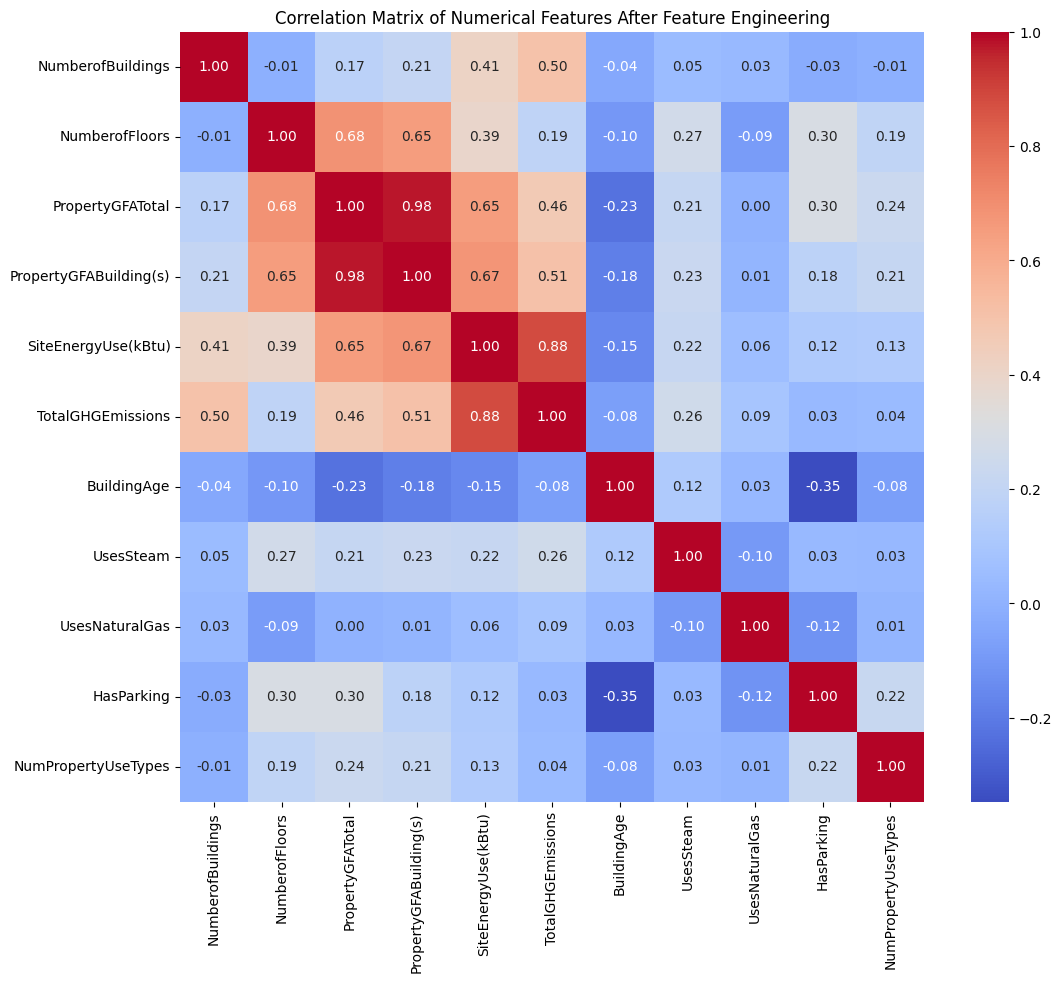

In [36]:
# Matrice de corrélation après feature engineering
plt.figure(figsize=(12,10))
numeric_cols = building_consumption.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = building_consumption[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features After Feature Engineering')
plt.show()

In [37]:
# Vérifier la présence de valeurs manquantes après le feature engineering
building_consumption.isna().mean().sort_values(ascending=False)

BuildingType              0.0
PrimaryPropertyType       0.0
NumberofBuildings         0.0
NumberofFloors            0.0
PropertyGFATotal          0.0
PropertyGFABuilding(s)    0.0
LargestPropertyUseType    0.0
SiteEnergyUse(kBtu)       0.0
TotalGHGEmissions         0.0
BuildingAge               0.0
UsesSteam                 0.0
UsesNaturalGas            0.0
HasParking                0.0
NumPropertyUseTypes       0.0
dtype: float64

In [38]:
# Supprimer les lignes avec des valeurs manquantes restantes
building_consumption = building_consumption.dropna()
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 0 to 3375
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            1520 non-null   object 
 1   PrimaryPropertyType     1520 non-null   object 
 2   NumberofBuildings       1520 non-null   float64
 3   NumberofFloors          1520 non-null   int64  
 4   PropertyGFATotal        1520 non-null   int64  
 5   PropertyGFABuilding(s)  1520 non-null   int64  
 6   LargestPropertyUseType  1520 non-null   object 
 7   SiteEnergyUse(kBtu)     1520 non-null   float64
 8   TotalGHGEmissions       1520 non-null   float64
 9   BuildingAge             1520 non-null   int64  
 10  UsesSteam               1520 non-null   int64  
 11  UsesNaturalGas          1520 non-null   int64  
 12  HasParking              1520 non-null   int64  
 13  NumPropertyUseTypes     1520 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usa

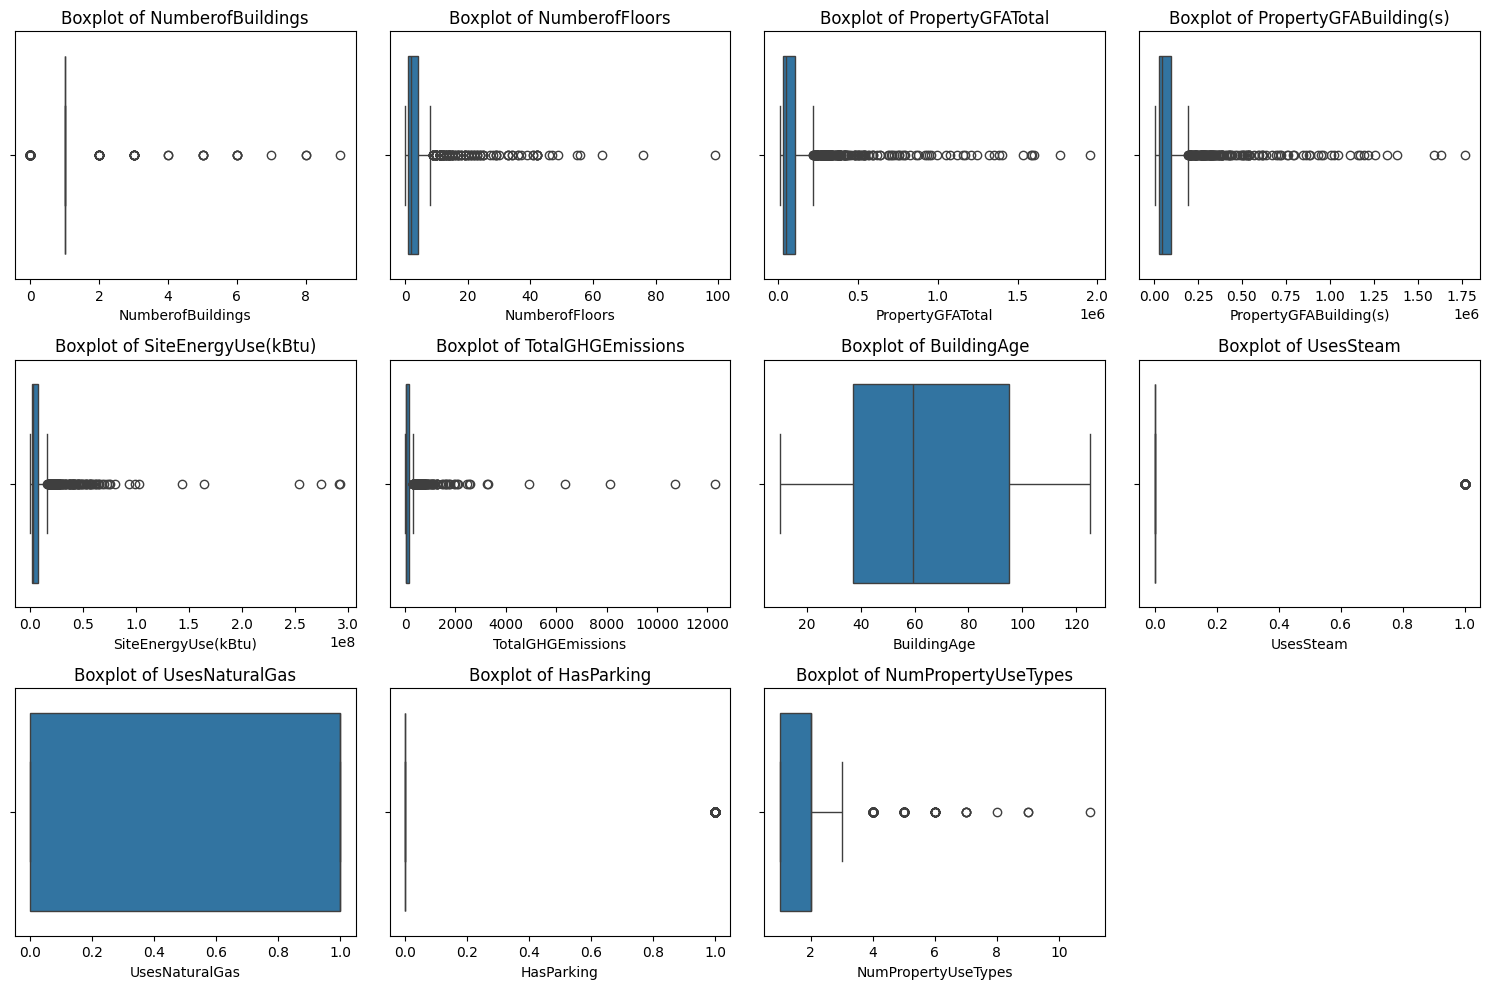

In [39]:
# Vérifier les outliers dans les variables numériques restantes
plt.figure(figsize=(15,10))
numeric_cols = building_consumption.select_dtypes(include=['float64', 'int64']).columns
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=building_consumption[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### Outliers : méthode IQR

In [40]:
# Simuler une méthode IQR pour détecter et supprimer les outliers dans les variables numériques et voir l'impact sur la taille d'un dataset provisoire
numeric_features = building_consumption.select_dtypes(include=['float64', 'int64']).columns
building_consumption_no_outliers = building_consumption.copy()
for col in numeric_features:
    Q1 = building_consumption_no_outliers[col].quantile(0.25)
    Q3 = building_consumption_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    building_consumption_no_outliers = building_consumption_no_outliers[
        (building_consumption_no_outliers[col] >= lower_bound) & 
        (building_consumption_no_outliers[col] <= upper_bound)
    ]
building_consumption_no_outliers.shape


(730, 14)

La méthode IQR a un impact trop important, trop peu de données avec l'application.

### Outliers méthode : Z-Score

In [41]:
# Faire la meme chose avec une méthode Z-score pour détecter et supprimer les outliers dans les variables numériques et voir l'impact sur la taille d'un dataset provisoire

numeric_features = building_consumption.select_dtypes(include=['float64', 'int64']).columns
building_consumption_zscore = building_consumption.copy()
z_scores = np.abs(stats.zscore(building_consumption_zscore[numeric_features]))
building_consumption_zscore = building_consumption_zscore[(z_scores < 3).all(axis=1)]
building_consumption_zscore.shape

(1336, 14)

In [42]:
building_consumption.shape

(1520, 14)

On perd des données mais cela va aider a améliorer l'entrainement des modèles sensibles aux outliers.

In [43]:
# On applique la méthode Z-score pour supprimer les outliers
#numeric_features = building_consumption.select_dtypes(include=['float64', 'int64']).columns
#z_scores = np.abs(stats.zscore(building_consumption[numeric_features]))
#building_consumption = building_consumption[(z_scores < 3).all(axis=1)]

### Z-Score enlévé car résultats plus mauvais avec moins de données

In [44]:
# Test de retirer LargestPropertyUseType du dataset
# building_consumption = building_consumption.drop(columns=['LargestPropertyUseType'])

In [45]:
# Garder une trace valeurs encodees et leur mapping et encoder les variables catégorielles
categorical_cols = ['BuildingType', 'LargestPropertyUseType', 'PrimaryPropertyType']
for col in categorical_cols:
    le = LabelEncoder()
    building_consumption[col] = le.fit_transform(building_consumption[col])
    # Sauvegarder le mapping
    mapping_df = pd.DataFrame({'Original': le.classes_, 'Encoded': le.transform(le.classes_)})
    mapping_df.to_csv(f'{col}_label_encoding_mapping.csv', index=False)
    # Sauvegarder le mapping dans un fichier texte
    with open(f'{col}_label_encoding_mapping.txt', 'w') as f:
        for original, encoded in zip(mapping_df['Original'], mapping_df['Encoded']):
            f.write(f"{original}: {encoded}\n")
    # Sauvegarder le mapping dans un seul dictionnaire JSON
    mapping_dict = dict(zip(mapping_df['Original'], mapping_df['Encoded']))
    
    with open(f'{col}_label_encoding_mapping.json', 'w') as f:
        json.dump(mapping_dict, f)   

In [46]:
# encoding_mappings = {}
# categorical_cols = ['LargestPropertyUseType', 'BuildingType', 'PrimaryPropertyType']
# for col in categorical_cols:
#     le = LabelEncoder()
#     building_consumption[col] = le.fit_transform(building_consumption[col])
#     encoding_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
# # Sauvegarder le mapping dans un fichier texte
# with open("encoding_mappings.txt", "w") as f:
#     for col, mapping in encoding_mappings.items():
#         f.write(f"Mapping for {col}:\n")
#         for original, encoded in mapping.items():
#             f.write(f"  {original} -> {encoded}\n")
#        f.write("\n")

In [47]:
# Encoder les variables catégorielles
#for col in categorical_cols:
    #le = LabelEncoder()
   # building_consumption[col] = le.fit_transform(building_consumption[col])

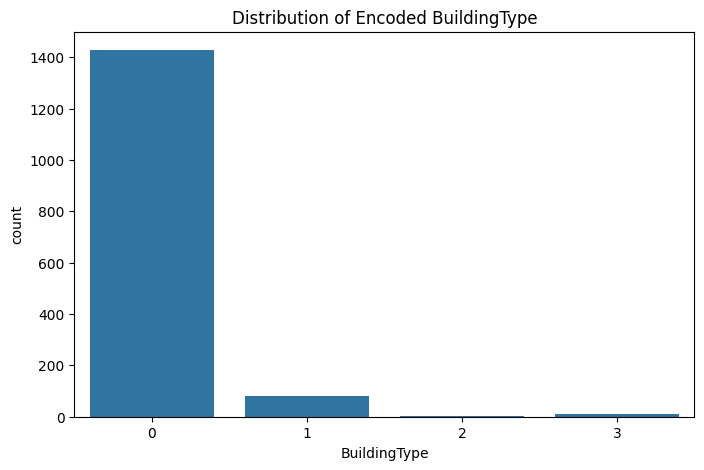

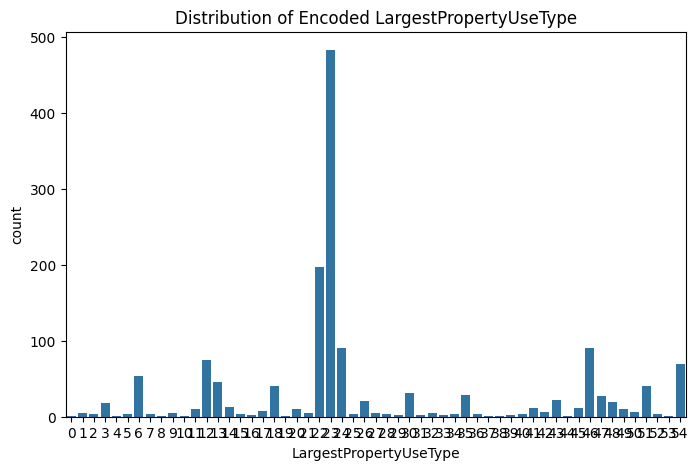

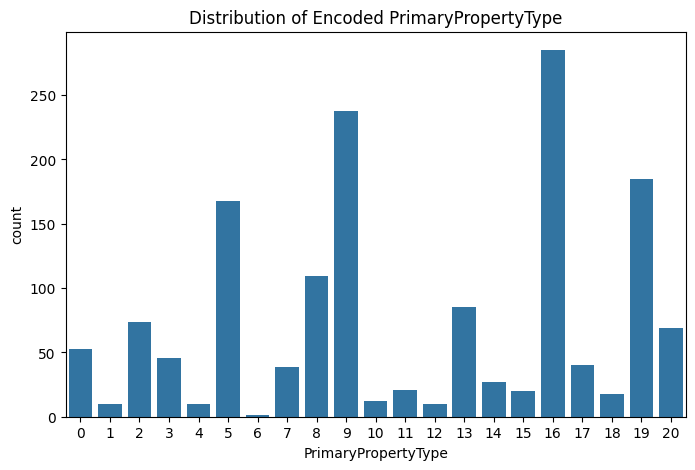

In [48]:
# Vérifier visuellement les valeurs encodées
for col in categorical_cols:
    plt.figure(figsize=(8,5))
    sns.countplot(x=building_consumption[col])
    plt.title(f'Distribution of Encoded {col}')
    plt.show()  

In [49]:
# Créer une variable X et y pour la modélisation
# On retire les colonnes cibles du jeu de features
X = building_consumption.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

# On choisit la target SiteEnergyUse(kBtu)
y = building_consumption['SiteEnergyUse(kBtu)']

In [50]:
# CODE PREPARATION DES FEATURES

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [51]:
# Réaliser une separation train/test via une validation croisée
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Entrainer et évaluer plusieurs modèles de régression

models = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}")



DummyRegressor - MSE: 328622050545147.44, R2: -0.00, MAE: 7979390.72
LinearRegression - MSE: 163630591611447.25, R2: 0.50, MAE: 5386661.37
RandomForestRegressor - MSE: 89948447807500.14, R2: 0.73, MAE: 3866065.65
SVR - MSE: 355460437546012.12, R2: -0.08, MAE: 6504602.50


R², MAE et RMSE servent à juger la qualité d’un modèle de régression, chacun sous un angle différent.

## R² (coefficient de détermination)
• Ce que ça dit: quelle part de la variabilité de la cible est expliquée par le modèle; 1 signifie “presque tout expliqué”, 0 “rien expliqué”, et une valeur négative signifie pire que prédire la moyenne .
• Lecture simple: R² = 0.68 veut dire qu’environ 68% des variations de la consommation observée sont captées par le modèle; plus c’est proche de 1, mieux c’est, mais ça ne garantit pas de bonnes prédictions futures ni l’absence de surapprentissage .

## MAE (Mean Absolute Error)
• Ce que ça dit: l’erreur moyenne en valeur absolue, dans les mêmes unités que la cible; “en moyenne, de combien se trompe-t-on” .
• Lecture simple: MAE = 4 000 000 kBtu signifie qu’en moyenne, les prédictions s’écartent de 4 millions de kBtu de la vraie valeur.

## RMSE (Root Mean Squared Error)
• Ce que ça dit: la racine de la MSE, donc une “erreur typique” aussi dans les unités de la cible, mais qui pèse davantage les grosses erreurs que le MAE.
• Lecture simple: utile pour pénaliser pénaliser fortement les grosses dérives; si RMSE est beaucoup plus grand que MAE, c’est qu’il existe des gros outliers/erreurs extrêmes.

Ce que disent les chiffres (source GPT5)

• Le DummyRegressor sert de baseline: R² ≈ 0 et erreurs très élevées, ce qui correspond à une prédiction “moyenne globale” sans signal; il fixe le niveau minimal à battre.

• LinearRegression: R² ≈ 0.68 et MAE ≈ 5.0e6 indiquent que 68% de la variance cible est expliquée et que l’erreur absolue moyenne est d’environ 5 millions d’unités de ta cible; c’est un gain net par rapport à la baseline.

• RandomForestRegressor: R² ≈ 0.69 et MAE ≈ 4.37e6, donc légèrement meilleur que la régression linéaire, surtout en MAE, ce qui suggère qu’il capture un peu de non-linéarité et réduit l’erreur moyenne par observation.

• SVR: R² négatif (-0.07) et MSE très élevé indiquent qu’il fait pire que la moyenne; le modèle est mal calibré pour cette échelle (hyperparamètres, features non standardisées ou cible très skewed) 

In [53]:
# Normaliser les données pour les modèles sensibles à l'échelle
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# Rejouer les modèles sur les données normalisées
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} (scaled) - MSE: {mse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}")



DummyRegressor (scaled) - MSE: 328622050545147.44, R2: -0.00, MAE: 7979390.72
LinearRegression (scaled) - MSE: 163630591611297.94, R2: 0.50, MAE: 5386661.37
RandomForestRegressor (scaled) - MSE: 88907960969398.02, R2: 0.73, MAE: 3868094.50
SVR (scaled) - MSE: 355461396392663.06, R2: -0.08, MAE: 6504628.55


### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [55]:
# Réaliser une GridSearchCV avec au moins 3 hyperparamètres sur le modèle RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


## Résultats du meilleur model avec GridSearchCV

In [56]:
# Montrer les résultats du modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Best RandomForestRegressor - MSE: {mse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}") 

Best RandomForestRegressor - MSE: 75019549708181.23, R2: 0.77, MAE: 3855365.16


## Feature importances

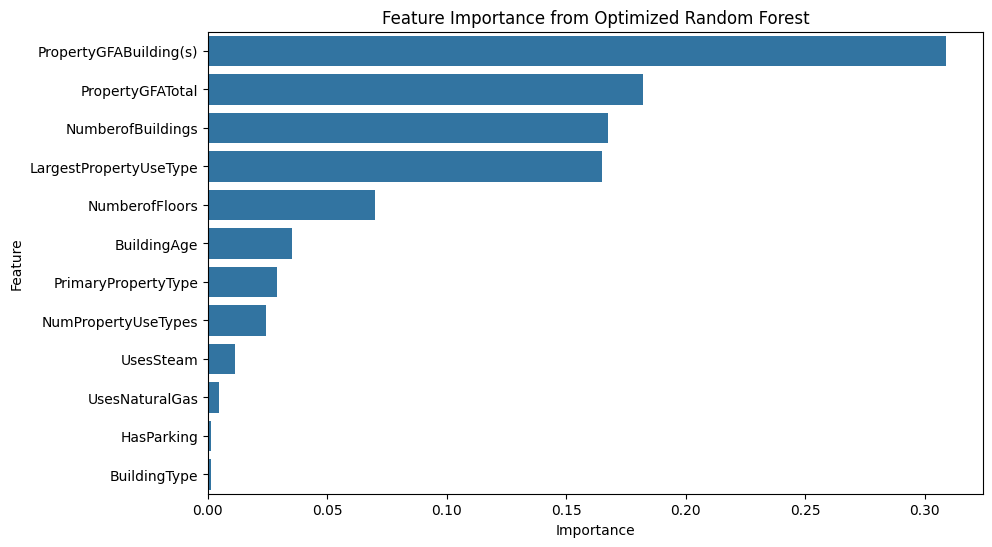

In [57]:
# Montrer la feature importance du modèle optimisé
best_rf = grid_search.best_estimator_
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False) 
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Optimized Random Forest')
plt.show()

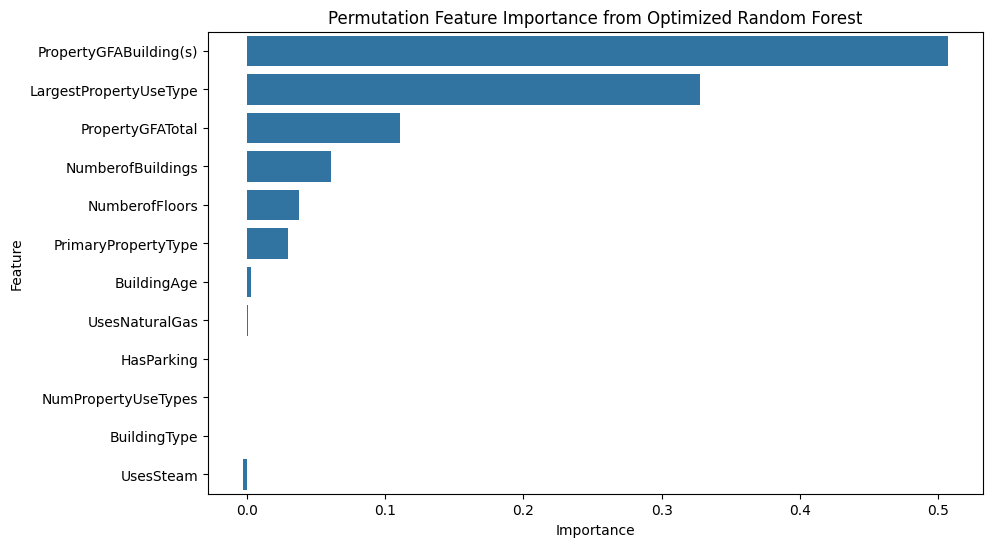

In [58]:
# Autre visualisation de la feature importance avec permutation importance
result = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df)
plt.title('Permutation Feature Importance from Optimized Random Forest')
plt.show()

# Sauvegarde dans BentoML

In [59]:
# Sauvegarder le modèle optimisé avec BentoML
  
bentoml.sklearn.save_model("energy_rf_model", best_rf)

Model(tag="energy_rf_model:m447ptwluojyvasd", path="/var/folders/rd/yrcxjrg952ngc0b02j2fk8_w0000gn/T/bentoml-model-energy_rf_model-h8x25zy0")

In [60]:
# Liste des features utilisées dans le modèle dans l'ordre utilisé par le modèle
feature_names.tolist()

['BuildingType',
 'PrimaryPropertyType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseType',
 'BuildingAge',
 'UsesSteam',
 'UsesNaturalGas',
 'HasParking',
 'NumPropertyUseTypes']